<a href="https://colab.research.google.com/github/yongtaoliu/MicroscopyHackathon/blob/main/MicroscopyHackathon_GPBO_Demo_for_Combi_Library_SmBFO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Bayesian Optimization for Combinatorial Library SmBFO Dataset


This notebook shows how Gaussian process Bayesian Optimization works in operating microscopy using a pre-acquired combinatoril library  piezoresponse spectrscopy (PS) data to simulate microscopy experiment.

The GPBO code is implemented using GPax
package https://github.com/ziatdinovmax/gpax.

* This workflow notebook is prepared by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en). Update date: Nov 2024
* The piezoresponse spectroscopy data is acquired by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) from a combinatorial library sample SmBFO synthesized by Ichiro Takeuchi group.

### **Further developments**
* We can also use structured Gaussian process to integrate physical hypothesis in the GP model to drive experiment, e.g., [example 1](https://onlinelibrary.wiley.com/doi/full/10.1002/adma.202201345) and [example 2](https://www.cell.com/action/showPdf?pii=S2666-3899%2823%2900041-7)


## Install & Import

Install GPax package:

In [1]:
!pip install -q gpax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.1/351.1 kB 11.6 MB/s eta 0:00:00


Import needed packages:

In [2]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

## Load SmBFO data

In [3]:
!wget https://github.com/yongtaoliu/MicroscopyHackathon/raw/main/SmBFO_NanoSurf.npz

--2024-11-13 16:21:05--  https://github.com/yongtaoliu/MicroscopyHackathon/raw/main/SmBFO_NanoSurf.npz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yongtaoliu/MicroscopyHackathon/main/SmBFO_NanoSurf.npz [following]
--2024-11-13 16:21:05--  https://raw.githubusercontent.com/yongtaoliu/MicroscopyHackathon/main/SmBFO_NanoSurf.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5574 (5.4K) [application/octet-stream]
Saving to: ‘SmBFO_NanoSurf.npz’

SmBFO_NanoSurf.npz  100%[===================>]   5.44K  --.-KB/s    in 0s      

2024-11-13 16:21:05 (49.0 MB/s) - ‘SmBFO_NanoSurf.npz’ saved [5574/55

In [4]:
smbfo = np.load("SmBFO_NanoSurf.npz")
print(smbfo.files)

x_composition = smbfo['composition']
y_nucleation = smbfo['nucleation_voltages']
y_coercive = smbfo['coercive_voltages']
y_looparea = smbfo['loop_area']

['composition', 'nucleation_voltages', 'coercive_voltages', 'loop_area']


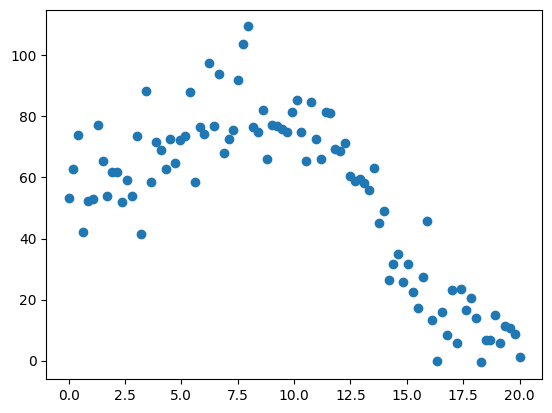

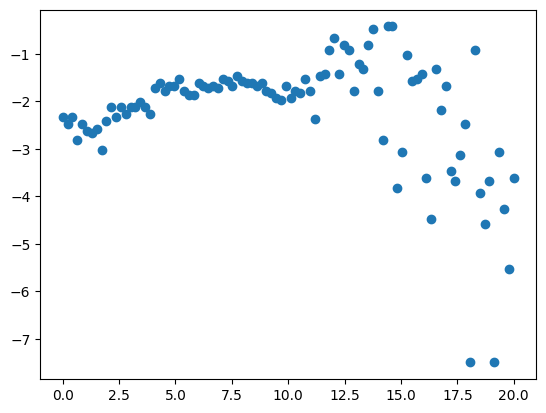

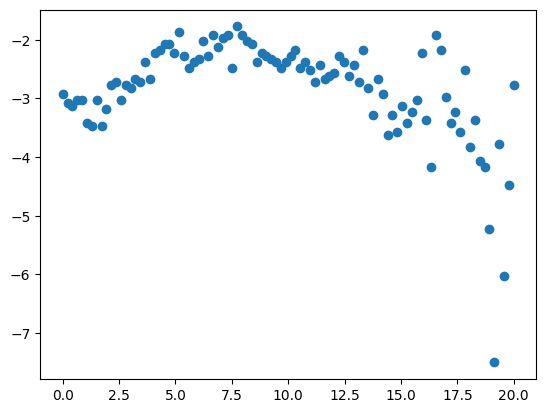

In [5]:
plt.scatter(x_composition, y_looparea, label='Loop Area')
plt.show()
plt.scatter(x_composition, y_nucleation[0], label='Nucleation Voltage')
plt.show()
plt.scatter(x_composition, y_coercive[0], label='Coercive Voltage')
plt.show()

### Create data

Generate some noisy observations:

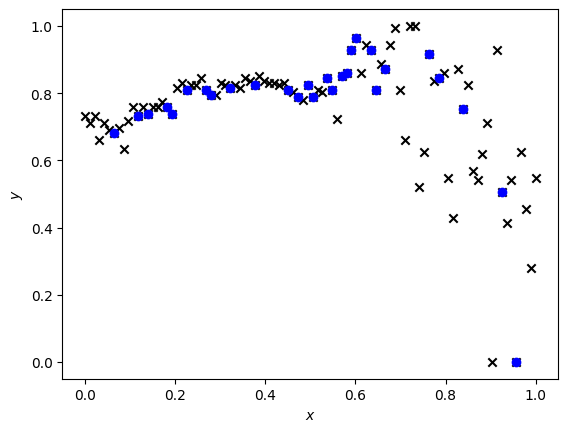

In [6]:
np.random.seed(0)

NUM_INIT_POINTS = 5 # number of observation points

def norm_(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))

# Select Experiment Data
X = norm_(np.asarray(x_composition))
y = norm_(np.asarray(y_nucleation[0]))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=2)

# Plot generated data
plt.figure(dpi=100)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(X, y, marker='x', c='k', zorder=1)
plt.scatter(X_train, y_train, marker='o', c='b', zorder=2)

### Standard GP

Next, we initialize and train a GP model. We are going to use an RBF kernel, $k_{RBF}=𝜎exp(-\frac{||x_i-x_j||^2}{2l^2})$, which is a "go-to" kernel functions in GP.

In [7]:
# Get random number generator keys for training and prediction
key1, key2 = gpax.utils.get_keys()

# Initialize model
gp_model = gpax.ExactGP(1, kernel='RBF')
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(key1, X_train, y_train, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:10<00:00, 375.57it/s, 7 steps of size 4.84e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.33      0.09      0.32      0.20      0.45    980.65      1.00
    k_scale      1.21      1.13      0.88      0.15      2.35   1149.34      1.00
      noise      0.01      0.00      0.01      0.00      0.01   1032.48      1.00



Now let's use our trained model to obtain a probabilistic prediction of function values on new ("test") data. In the fully Bayesian mode, we get a pair of predictive mean and covariance, $𝜇_*^i$ and $𝛴^i_*$, for each *i*-th HMC sample with kernel parameters $𝜃$,

$$𝜇_*^i=K(X_*,X|𝜃^i)K(X,X|𝜃^i)^{-1}y$$
$$𝛴^i_*=K(X_*,X_*|𝜃^i)-K(X_*,X|𝜃^i)K(X,X|𝜃^i)^{-1}K(X,X_*|𝜃^i)$$

The ```.predict()``` method returns the center of the mass of all the predictive means,

$$𝜇^{post}_*= \frac{1}{L} ∑_{i=1}^L 𝜇_*^i,$$

which corresponds to the ```posterior_mean``` in the code cell below, and
samples

$$f_*^i∼MVNormal(𝜇^i_*, 𝛴^i_*)$$

from multivariate normal distributions for all the pairs of predictive means and covariances (```f_samples``` in the code cell below). Note that model noise is absorbed into the kernel computation function.

In [8]:
# Get the GP prediction. Here n stands for the number of samples from each MVNormal distribution
# (the total number of MVNormal distributions is equal to the number of HMC samples)
posterior_mean, f_samples = gp_model.predict(key2, X_test, n=200)

Plot the obtained results:

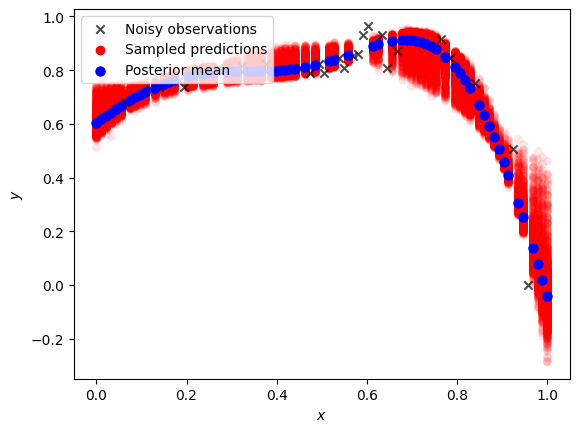

In [9]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X_train, y_train, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in f_samples:
    ax.scatter(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l = ax.scatter(X_test, f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.scatter(X_test, posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.legend(loc='upper left')
l.set_alpha(0)

# Perform GP exploration

In [10]:
import jax.numpy as jnp
# Help function for initilizing training
def init_training_data_exp(X, Y, num_seed_points=2, rng_seed=42, list_of_indices=None):
    np.random.seed(rng_seed)
    indices = jnp.arange(len(X))
    idx = list_of_indices
    if idx is not None:
        idx = np.array(idx)
    else:
        idx = np.random.randint(0, len(X), num_seed_points)
    idx = np.unique(idx)
    X_train, y_train = X[idx], Y[idx]
    indices_train = indices[idx]
    X_test = jnp.delete(X, idx)
    y_test = jnp.delete(Y, idx, 0)
    indices_test = jnp.delete(indices, idx)
    return X_train, y_train, X_test, y_test, indices_train, indices_test

# Help function for updating train/test data
def update_data(next_point_idx, X_train, X_test, y_train, y_test, indices_train, indices_test):
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, y_test[next_point_idx][None], 0)
    y_test = jnp.delete(y_test, next_point_idx, 0)
    indices_train = jnp.append(indices_train, indices_test[next_point_idx])
    indices_test = jnp.delete(indices_test, next_point_idx)
    return X_train, X_test, y_train, y_test, indices_train, indices_test

In [11]:
# Function for performing a GP step, here we use structure GP (sGP)
def run_GP (xtrain, ytrain, xtest, fn = None, fn_priors = None):
  rng_key, rng_key_predict = gpax.utils.get_keys(1)
  # Obtain/update GP posterior
  gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=fn, mean_fn_prior=fn_priors)
  gp_model.fit(rng_key, xtrain, ytrain)
  # Compute acquisition function
  obj = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test)
  # Get GP prediction
  posterior_mean, f_samples = gp_model.predict(rng_key_predict, xtest, n = 200)
  return gp_model, obj, posterior_mean, f_samples

### Initialize training data

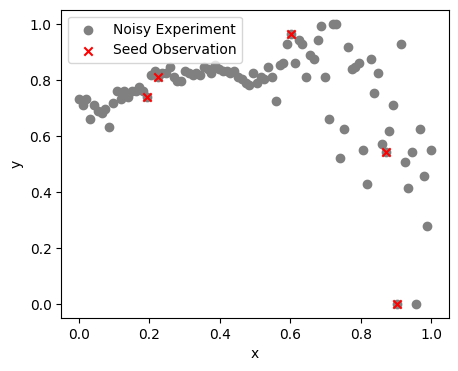

In [12]:
# Select random initial points
init_points = 5 # number of initial points

# Full dataset
X = jnp.asarray(X)
y = jnp.asarray(y)
X = norm_(X)
y = norm_(y)

# initialize training data
(X_train, y_train, X_test, y_test,
 indices_train, indices_test) = init_training_data_exp(X, y, num_seed_points=init_points, rng_seed=1)

# Plot initial trian dataset
plt.figure(figsize = (5, 4))
plt.scatter(X, y, label = "Noisy Experiment", color = "Gray")
plt.scatter(X_train, y_train, label = "Seed Observation", color = 'red', marker = 'x')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### Start GP exploration


Exploration step 1


sample: 100%|██████████| 4000/4000 [00:05<00:00, 769.42it/s, 3 steps of size 7.45e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.87      1.95      1.25      0.07      4.00   1646.19      1.00
    k_scale      1.06      1.12      0.71      0.06      2.28   1585.24      1.00
      noise      0.46      0.43      0.34      0.05      0.94   1660.09      1.00



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


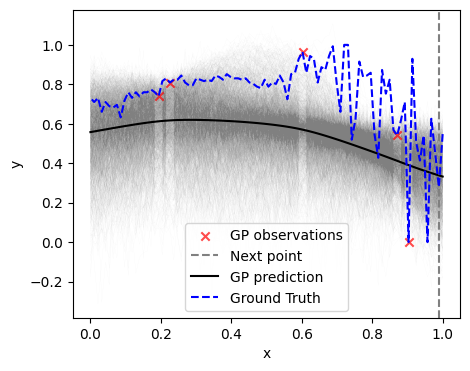


Exploration step 2


sample: 100%|██████████| 4000/4000 [00:05<00:00, 724.83it/s, 3 steps of size 8.12e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.90      2.20      1.23      0.09      4.06   1410.60      1.00
    k_scale      1.04      1.23      0.69      0.06      2.14   1343.45      1.00
      noise      0.36      0.33      0.27      0.05      0.73   1606.52      1.00



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
rng_key, rng_key_predict = gpax.utils.get_keys(1)
exploration_steps = 20

for i in range(exploration_steps):
    print("\nExploration step {}".format(i+1))
    # Execute GP
    gpbo, obj, posterior_mean, f_samples = run_GP(X_train, y_train, X_test)
    # Next point
    # get the next point to measure
    next_point_idx = obj.argmax()
    next_point = X_test[next_point_idx]
    y_next = y_test[next_point_idx]

    # Plot results-------------------------
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.scatter(X_train, y_train, marker='x', c='r', zorder=1, label="GP observations", alpha=0.7)
    ax.axvline(next_point, linestyle = "--", c = "Gray", label="Next point")
    for y1 in f_samples:
      ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='Gray', alpha=.1)
    l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='Gray', alpha=1)
    ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='black', label='GP prediction')
    ax.plot(X, y, c='blue', linestyle='--', label='Ground Truth')
    ax.legend();
    l.set_alpha(0)
    plt.show()
    #------------------------------------------#
    # Update Train and Test datasets
    (X_train, X_test, y_train, y_test,
     indices_train, indices_test) = update_data(next_point_idx, X_train, X_test, y_train,
                                                y_test, indices_train, indices_test)